In [1]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd;
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import os
import sys
import shutil
import keras
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from spektral.data.utils import to_tf_signature, prepend_none
from spektral.data import DisjointLoader, Dataset
from spektral.transforms import GCNFilter, NormalizeAdj
import scipy.sparse
from spektral.data.graph import Graph
from keras.layers import Dense, concatenate, Dropout
from keras import Model

In [2]:
features = pd.read_csv('thingi10k_data.csv', index_col=0)
adjpath = '../Data/stl/adjacency_stl_simplified/'
cloudpath = '../Data/stl/nodefeatures_stl_simplified/'
edgepath = '../Data/stl/edgefeaturesmatrix_stl_simplified/'

In [3]:
#Read data, drop unnecessary
data = pd.read_csv('thingi10k_data.csv', index_col=0)

df = data.copy()
df.drop("source", axis=1, inplace=True)
df.drop("model_name", axis=1, inplace=True)

#Extract build times
build_times = df["build_time"]
df.drop("build_time", axis=1,inplace=True)

#Make pipeline
def log_transform(x):
    return np.log(x + 1)

def inv_log_transform(x):
    return np.exp(x) - 1 

logtransformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, check_inverse=False)
pipe = Pipeline(steps=[ ('logtransformer', logtransformer)])

#Log transform
transformed = pipe.fit_transform(df)
df = np.asarray(transformed)
build_times = np.asarray(build_times)

In [4]:
#Graph dataset
class MyDataset(Dataset):
    def __init__(self, centroids, dev, index, **kwargs):
        self.centroids = centroids
        self.dev = dev
        self.index = index
        super().__init__(**kwargs)

    def read(self):
        output = []
        for i in self.index:
            if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
                point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
                edgefeat = scipy.sparse.load_npz(edgepath + f'{features["model_name"][i]}.npz')
                output.append(
                    Graph(x=((point_cloud-self.centroids)/self.dev), a=edgefeat, y=features["build_time"][i])
                )
            else:
                print(f'object {i} missing!')

        return output

In [5]:
def get_split_graphs(trainindex, testindex):
    print("Getting split...")
    coords = np.empty((1,3))

    for i in trainindex:
        if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
            point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
            coords = np.concatenate((coords,point_cloud))
            

    coords = np.delete(coords,0,0)
    centroids = np.mean(coords,0)
    coordscentered = coords - centroids
    dev = np.max(np.sqrt(np.sum(coordscentered**2,axis=-1) / (trainindex.shape[0] - 1)))

    train = MyDataset(centroids, dev, trainindex)
    test = MyDataset(centroids, dev, testindex)
    validation = MyDataset(centroids, dev, range(3478,3661))
    train.apply(NormalizeAdj())
    test.apply(NormalizeAdj())
    validation.apply(NormalizeAdj())
    train = DisjointLoader(train, batch_size=32)
    test = DisjointLoader(test, batch_size=32)
    validation = DisjointLoader(validation, batch_size=32)
    
    return train, test, validation

In [6]:
#Define callbacks
def get_callbacks(weights_file, patience, lr_factor):
  return [
      # Only save the weights that correspond to the minimum mape.
      ModelCheckpoint(filepath= weights_file,
                      monitor="val_mape", 
                      mode="min",
                      save_best_only=True, 
                      save_weights_only=False),
      # If val_loss doesn't improve for a number of epochs set with 'patience' var 
      # training will stop to avoid overfitting.    
      EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = patience,
                    verbose=1),
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="val_loss", mode="min",
                        factor=lr_factor, min_lr=1e-8, patience=patience//2, verbose=1)]

In [7]:
#util
def reset_model(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel.initializer') and layer.trainable: 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias.initializer') and layer.trainable:
            layer.bias.initializer.run(session=session)

def make_trainable(model):
    for layer in model.layers:
        layer.trainable = True

In [8]:
#Validation
def cross_validate(model, dir):
    loss_per_fold = []
    mae_per_fold = []
    mape_per_fold = []
    validation_per_fold = []
    batch_size = 32
    verbosity = 1
    no_epochs = 1000
    kfold = KFold(n_splits=5, shuffle=True)


    print('multi-input')
    fold_no = 1
    for train, test in kfold.split(df[0:3478], build_times[0:3478]):

        reset_model(model)
        trainloader, testloader, validationloader = get_split_graphs(train, test)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        model.compile(loss='mape',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #0.001
            metrics=['mae','mape']
        )
        history = model.fit(trainloader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=trainloader.steps_per_epoch,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            callbacks=get_callbacks(f'{dir}_{fold_no}',
                                        patience=60,
                                        lr_factor=0.3))
        model = keras.models.load_model(f"{dir}_{fold_no}")
    
        # Generate generalization metrics
        valscores = model.evaluate(validationloader.load(), steps=validationloader.steps_per_epoch, batch_size=32, verbose=0)
        validation_per_fold.append(valscores)
        scores = model.evaluate(testloader.load(), steps=testloader.steps_per_epoch, batch_size=32, verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]}%;')
        loss_per_fold.append(scores[0])
        mae_per_fold.append(scores[1])
        mape_per_fold.append(scores[2])

        # Increase fold number
        fold_no = fold_no + 1

    return loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold

    

In [9]:
#Print scores
def print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold):
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(loss_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Mean average error: {mae_per_fold[i]}% - Mean percentage error: {mape_per_fold[i]}%')
        print(f'    Score on unseen data: Loss: {validation_per_fold[i][0]} - Mean average error: {validation_per_fold[i][1]}% - Mean percentage error: {validation_per_fold[i][2]}%')
        print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> Mean average error: {np.mean(mae_per_fold)}')
    print(f'> Mean percentage error: {np.mean(mape_per_fold)}')
    print(f'> Unseen Loss: {np.mean(np.asarray(validation_per_fold)[:,0])}')
    print(f'> Unseen Mean average error: {np.mean(np.asarray(validation_per_fold)[:,1])}')
    print(f'> Unseen Mean percentage error: {np.mean(np.asarray(validation_per_fold)[:,2])}')
    print('------------------------------------------------------------------------')
    

In [10]:
#Hybrid Reset
model = keras.models.load_model("savedmodels/GCN_simplified_normalized")
make_trainable(model)
loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, "crossvalidationmodels/GCN")

multi-input
Getting split...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 44.7116 - mae: 203.0311 - mape: 40.6507

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_1\assets


87/87 [==============================] - 9s 87ms/step - loss: 44.7116 - mae: 203.0311 - mape: 40.6507 - val_loss: 43.7918 - val_mae: 169.8668 - val_mape: 39.7309 - lr: 0.0010
Epoch 2/1000
 1/87 [..............................] - ETA: 7s - loss: 49.2595 - mae: 79.9885 - mape: 45.1985

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 42.1963 - mae: 200.5422 - mape: 38.1405

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_1\assets


87/87 [==============================] - 8s 88ms/step - loss: 42.1963 - mae: 200.5422 - mape: 38.1405 - val_loss: 40.9569 - val_mae: 172.0337 - val_mape: 36.8970 - lr: 0.0010
Epoch 3/1000
 1/87 [..............................] - ETA: 6s - loss: 52.0761 - mae: 502.2348 - mape: 48.0162

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 76ms/step - loss: 42.3710 - mae: 201.0967 - mape: 38.3200 - val_loss: 43.1083 - val_mae: 168.8712 - val_mape: 39.0625 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 75ms/step - loss: 43.3697 - mae: 200.7721 - mape: 39.3239 - val_loss: 47.1695 - val_mae: 175.8879 - val_mape: 43.1213 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 75ms/step - loss: 43.4295 - mae: 201.3985 - mape: 39.3712 - val_loss: 42.1675 - val_mae: 172.4078 - val_mape: 38.1016 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 76ms/step - loss: 42.5319 - mae: 201.6146 - mape: 38.4635 - val_loss: 42.8498 - val_mae: 169.5627 - val_mape: 38.7719 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 76ms/step - loss: 41.8970 - mae: 201.1266 - mape: 37.8291 - val_loss: 42.7930 - val_mae: 170.8400 - val_mape: 38.7213 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 76ms/step - loss

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 1: loss of 40.95688247680664; mae of 172.03375244140625; mape of 36.897010803222656%;
Getting split...
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 44.4619 - mae: 202.2647 - mape: 40.4084

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_2\assets


87/87 [==============================] - 8s 87ms/step - loss: 44.4619 - mae: 202.2647 - mape: 40.4084 - val_loss: 43.6590 - val_mae: 168.2351 - val_mape: 39.6034 - lr: 0.0010
Epoch 2/1000
 1/87 [..............................] - ETA: 7s - loss: 50.4378 - mae: 360.5072 - mape: 46.3821

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 43.4560 - mae: 201.5322 - mape: 39.3905

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_2\assets


87/87 [==============================] - 8s 91ms/step - loss: 43.4560 - mae: 201.5322 - mape: 39.3905 - val_loss: 39.2916 - val_mae: 165.2457 - val_mape: 35.2344 - lr: 0.0010
Epoch 3/1000
 1/87 [..............................] - ETA: 7s - loss: 43.8430 - mae: 69.7069 - mape: 39.7857

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 78ms/step - loss: 42.8472 - mae: 202.1337 - mape: 38.7865 - val_loss: 39.7288 - val_mae: 166.3784 - val_mape: 35.6641 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 77ms/step - loss: 42.7309 - mae: 202.2215 - mape: 38.6670 - val_loss: 41.9181 - val_mae: 170.1150 - val_mape: 37.8630 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 77ms/step - loss: 41.7406 - mae: 201.6278 - mape: 37.6733 - val_loss: 42.3455 - val_mae: 167.7996 - val_mape: 38.2780 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 76ms/step - loss: 43.5627 - mae: 201.8232 - mape: 39.4924 - val_loss: 41.3152 - val_mae: 165.2830 - val_mape: 37.2419 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 77ms/step - loss: 42.0693 - mae: 200.6381 - mape: 37.9909 - val_loss: 40.9222 - val_mae: 166.2682 - val_mape: 36.8428 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 77ms/step - loss

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 2: loss of 39.2916374206543; mae of 165.24569702148438; mape of 35.234371185302734%;
Getting split...
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 43.8057 - mae: 191.2368 - mape: 39.7699

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_3\assets


87/87 [==============================] - 9s 89ms/step - loss: 43.8057 - mae: 191.2368 - mape: 39.7699 - val_loss: 43.6489 - val_mae: 219.7684 - val_mape: 39.6225 - lr: 0.0010
Epoch 2/1000
 1/87 [..............................] - ETA: 8s - loss: 47.0921 - mae: 77.3245 - mape: 43.0657

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 42.8000 - mae: 190.8939 - mape: 38.7650

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_3\assets


87/87 [==============================] - 8s 95ms/step - loss: 42.8000 - mae: 190.8939 - mape: 38.7650 - val_loss: 40.3372 - val_mae: 213.3764 - val_mape: 36.3026 - lr: 0.0010
Epoch 3/1000
 1/87 [..............................] - ETA: 5s - loss: 38.2404 - mae: 186.8742 - mape: 34.2058

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 42.4025 - mae: 190.5739 - mape: 38.3547 - val_loss: 40.8481 - val_mae: 211.9333 - val_mape: 36.7988 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 77ms/step - loss: 41.9783 - mae: 189.8250 - mape: 37.9263 - val_loss: 44.5553 - val_mae: 217.6388 - val_mape: 40.5010 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 80ms/step - loss: 42.8225 - mae: 190.9502 - mape: 38.7531 - val_loss: 42.7179 - val_mae: 213.1712 - val_mape: 38.6400 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 78ms/step - loss: 42.7750 - mae: 189.5205 - mape: 38.6960 - val_loss: 44.1427 - val_mae: 215.9239 - val_mape: 40.0628 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 80ms/step - loss: 43.1214 - mae: 191.2278 - mape: 39.0392 - val_loss: 42.6103 - val_mae: 212.9691 - val_mape: 38.5379 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 78ms/step - loss

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 3: loss of 40.337196350097656; mae of 213.3764190673828; mape of 36.30261993408203%;
Getting split...
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 43.6645 - mae: 191.2348 - mape: 39.6535

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_4\assets


87/87 [==============================] - 9s 89ms/step - loss: 43.6645 - mae: 191.2348 - mape: 39.6535 - val_loss: 40.9966 - val_mae: 216.2002 - val_mape: 36.9825 - lr: 0.0010
Epoch 2/1000
 1/87 [..............................] - ETA: 8s - loss: 43.4459 - mae: 879.7827 - mape: 39.4318

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 42.2162 - mae: 189.2083 - mape: 38.2057 - val_loss: 44.7888 - val_mae: 223.5993 - val_mape: 40.7895 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - ETA: 0s - loss: 42.1463 - mae: 189.5932 - mape: 38.1378

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_4\assets


87/87 [==============================] - 8s 88ms/step - loss: 42.1463 - mae: 189.5932 - mape: 38.1378 - val_loss: 40.9197 - val_mae: 215.4016 - val_mape: 36.9016 - lr: 0.0010
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 80ms/step - loss: 41.6095 - mae: 189.4294 - mape: 37.5954 - val_loss: 41.8610 - val_mae: 219.3670 - val_mape: 37.8475 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 78ms/step - loss: 42.6141 - mae: 189.5941 - mape: 38.6021 - val_loss: 44.0939 - val_mae: 216.4114 - val_mape: 40.0848 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 78ms/step - loss: 42.2781 - mae: 189.8389 - mape: 38.2617 - val_loss: 43.1165 - val_mae: 220.0111 - val_mape: 39.0913 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 77ms/step - loss: 41.5168 - mae: 189.1750 - mape: 37.4798 - val_loss: 42.8077 - val_mae: 218.4096 - val_mape: 38.7735 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 79ms/step - loss: 42.2860 - mae: 189.9040 - mape: 38.2402 - val_loss: 41.7667 - val_mae: 215.7108 - val_mape: 37.7247 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 79ms/step - loss

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 4: loss of 40.91968536376953; mae of 215.40164184570312; mape of 36.90154266357422%;
Getting split...
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 0s - loss: 44.2105 - mae: 191.9211 - mape: 40.2116

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_5\assets


87/87 [==============================] - 9s 88ms/step - loss: 44.1708 - mae: 193.0831 - mape: 40.1718 - val_loss: 39.0157 - val_mae: 200.7546 - val_mape: 35.0059 - lr: 0.0010
Epoch 2/1000
 1/87 [..............................] - ETA: 6s - loss: 45.2871 - mae: 188.0762 - mape: 41.2773

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 80ms/step - loss: 44.0188 - mae: 192.5139 - mape: 40.0114 - val_loss: 40.3293 - val_mae: 207.0613 - val_mape: 36.3326 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - ETA: 0s - loss: 43.3428 - mae: 192.8396 - mape: 39.3311

INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\GCN_5\assets


87/87 [==============================] - 8s 88ms/step - loss: 43.3428 - mae: 192.8396 - mape: 39.3311 - val_loss: 38.1645 - val_mae: 203.0934 - val_mape: 34.1468 - lr: 0.0010
Epoch 4/1000
 1/87 [..............................] - ETA: 7s - loss: 38.3567 - mae: 177.3428 - mape: 34.3390

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 80ms/step - loss: 43.1315 - mae: 192.4503 - mape: 39.1091 - val_loss: 42.6088 - val_mae: 209.3272 - val_mape: 38.5856 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 78ms/step - loss: 43.8589 - mae: 193.6248 - mape: 39.8319 - val_loss: 38.7552 - val_mae: 201.9466 - val_mape: 34.7218 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 77ms/step - loss: 42.1804 - mae: 190.5826 - mape: 38.1498 - val_loss: 39.0236 - val_mae: 203.3042 - val_mape: 34.9964 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 78ms/step - loss: 43.0015 - mae: 192.3601 - mape: 38.9757 - val_loss: 40.3981 - val_mae: 205.6884 - val_mape: 36.3755 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 79ms/step - loss: 42.8114 - mae: 191.1437 - mape: 38.7783 - val_loss: 40.7010 - val_mae: 206.4584 - val_mape: 36.6629 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 79ms/step - loss

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 5: loss of 38.16448211669922; mae of 203.0933837890625; mape of 34.14677429199219%;


In [11]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 40.95688247680664 - Mean average error: 172.03375244140625% - Mean percentage error: 36.897010803222656%
    Score on unseen data: Loss: 46.48915100097656 - Mean average error: 365.64788818359375% - Mean percentage error: 42.42927932739258%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 39.2916374206543 - Mean average error: 165.24569702148438% - Mean percentage error: 35.234371185302734%
    Score on unseen data: Loss: 45.855106353759766 - Mean average error: 362.9642333984375% - Mean percentage error: 41.79783248901367%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 40.337196350097

<function matplotlib.pyplot.show(close=None, block=None)>

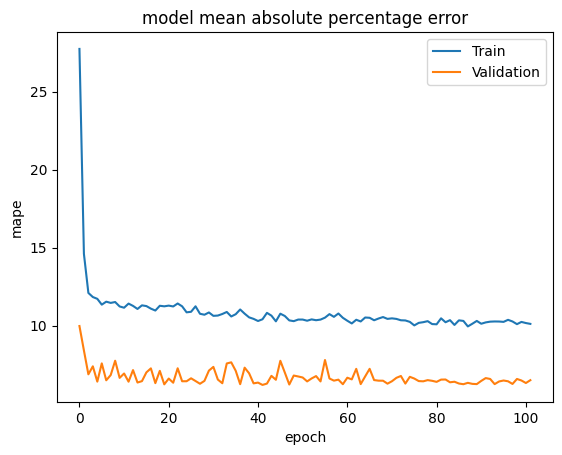

In [15]:
#Plot mape
plt.plot(model.history.history["mape"], label='Train')
plt.plot(model.history.history["val_mape"], label='Validation')
plt.legend()
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
#plt.ylim([35, 150])
#plt.xlim([0, 250])
plt.show